In [22]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [23]:
mnist = keras.datasets.mnist
(train_images_mnist,train_labels_mnist),(test_images_mnist,test_labels_mnist) = mnist.load_data()
# images are reshaped to be used by the flow method of a keras ImageGenerator
train_images_mnist = np.reshape(train_images_mnist,(train_images_mnist.shape[0],28,28,1))  
test_images_mnist = np.reshape(test_images_mnist,(test_images_mnist.shape[0],28,28,1))

train_images_mnist.shape

(60000, 28, 28, 1)

In [4]:
AZ_data = pd.read_csv('A_Z Handwritten Data.csv',header = None)
# the first column contains label values, while the remaining are the flattened array of 28 x 28 image pixels
AZ_labels = AZ_data.values[:,0]
AZ_images = AZ_data.values[:,1:]
# images are reshaped to be used by the flow method of a keras ImageGenerator
AZ_images = np.reshape(AZ_images,(AZ_images.shape[0],28,28,1))

In [5]:
# join datasets
# split AZ data in train and test
from sklearn.model_selection import train_test_split

test_size = float(len(test_labels_mnist))/len(train_labels_mnist)
print(f'test set size: {test_size}')
train_images_AZ, test_images_AZ, train_labels_AZ, test_labels_AZ = train_test_split(AZ_images,AZ_labels, test_size=test_size)
#shift mnist labels 
train_labels_mnist = train_labels_mnist + max(AZ_labels)+1
test_labels_mnist = test_labels_mnist + max(AZ_labels)+1

# concatenate datasets
train_images = np.concatenate((train_images_AZ,train_images_mnist),axis=0)
train_labels = np.concatenate((train_labels_AZ,train_labels_mnist))
test_images = np.concatenate((test_images_AZ,test_images_mnist),axis=0)
test_labels = np.concatenate((test_labels_AZ,test_labels_mnist))

print('Data ready')

test set size: 0.16666666666666666
Data ready


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Flow training images in batches using generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=50, shuffle=True)
validation_generator = test_datagen.flow(test_images, test_labels, batch_size=50, shuffle=True)

In [35]:
resnet152=tf.keras.applications.ResNet50(include_top=False,weights=None,input_shape=(56,56,1))
for i in resnet152.layers[:-5]:
    i.trainable=False

In [44]:

from tensorflow.keras.optimizers import Adam
pretrained_model=tf.keras.Sequential([
    tf.keras.layers.Input((28,28,1)),
    tf.keras.layers.UpSampling2D((2,2)),
    resnet152,
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(len(np.unique(train_labels)), activation='softmax')  

])
pretrained_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 56, 56, 1)        0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23581440  
                                                                 
 dropout_9 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_10 (Flatten)        (None, 8192)              0         
                                                                 
 dense_19 (Dense)            (None, 36)                294948    
                                                                 
Total params: 23,876,388
Trainable params: 1,349,668
Non-trainable params: 22,526,720
_________________________________

In [46]:
pretrained_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = pretrained_model.fit(
      train_generator,
      steps_per_epoch=500,  
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,  
      verbose=1)


Epoch 1/50
500/500 [==============================] - 69s 135ms/step - loss: 1.0357 - accuracy: 0.7152 - val_loss: 0.5747 - val_accuracy: 0.8468
Epoch 2/50
500/500 [==============================] - 67s 135ms/step - loss: 0.9487 - accuracy: 0.7372 - val_loss: 0.5733 - val_accuracy: 0.8464
Epoch 3/50
500/500 [==============================] - 66s 133ms/step - loss: 0.8971 - accuracy: 0.7493 - val_loss: 0.5384 - val_accuracy: 0.8500
Epoch 4/50
500/500 [==============================] - 71s 142ms/step - loss: 0.8596 - accuracy: 0.7553 - val_loss: 0.5710 - val_accuracy: 0.8320
Epoch 5/50
500/500 [==============================] - 73s 145ms/step - loss: 0.8016 - accuracy: 0.7766 - val_loss: 0.5504 - val_accuracy: 0.8388
Epoch 6/50
500/500 [==============================] - 67s 135ms/step - loss: 0.7921 - accuracy: 0.7754 - val_loss: 0.4944 - val_accuracy: 0.8596
Epoch 7/50
500/500 [==============================] - 70s 141ms/step - loss: 0.7645 - accuracy: 0.7825 - val_loss: 0.4774 - val_ac

In [47]:
pretrained_model.save('resnet50')

INFO:tensorflow:Assets written to: resnet50\assets


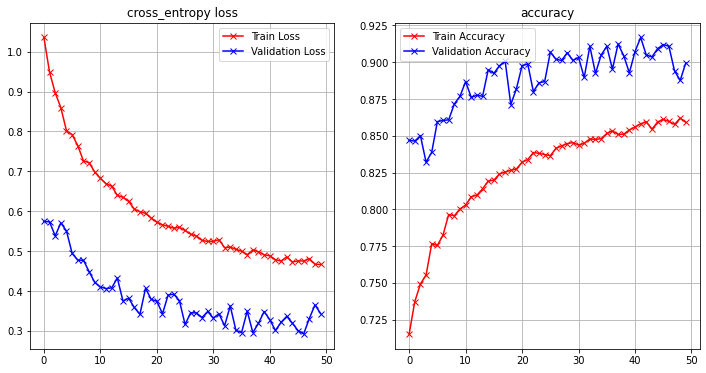

In [48]:
import matplotlib.pyplot as plt
    

    # Print accuracy and loss function
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history["loss"],'r-x', label="Train Loss")
ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
ax.legend()
ax.set_title('cross_entropy loss')
ax.grid(True)


ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
ax.legend()
ax.set_title('accuracy')
ax.grid(True)

In [104]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

import imutils
from imutils.contours import sort_contours

In [105]:
model_path = 'resnet50'
print("Loading NN model...")
model = load_model(model_path)
print("Done")

Loading NN model...
Done


In [106]:
image_path = 'at_night.png'
image = cv2.imread(image_path)


Text(0.5, 1.0, 'blurred image')

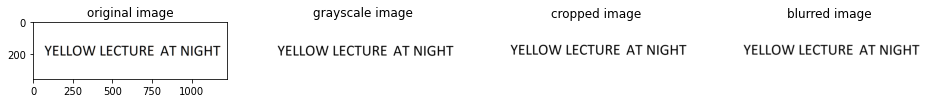

In [107]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cropped = gray[5:,:]
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)


%matplotlib inline
from matplotlib import cm
fig = plt.figure(figsize=(16,4))
ax = plt.subplot(1,4,1)
ax.imshow(image)
ax.set_title('original image')

ax = plt.subplot(1,4,2)
ax.imshow(gray,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('grayscale image')

ax = plt.subplot(1,4,3)
ax.imshow(cropped,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('cropped image')

ax = plt.subplot(1,4,4)
ax.imshow(blurred,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('blurred image')
#plt.imshow(gray,cmap=cm.binary_r)

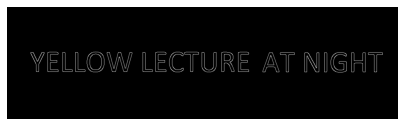

In [108]:
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 250) #low_threshold, high_threshold
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

figure = plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(edged,cmap=cm.binary_r)

In [109]:
import numpy as np
chars = []
mylist_w=[]
mylist_x=[]
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour and isolate ROI
  (x, y, w, h) = cv2.boundingRect(c)
  roi = cropped[y:y + h, x:x + w]
  mylist_x.append(x)
  mylist_w.append(x+w)
  
  #binarize image, finds threshold with OTSU method
  thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  
  # resize largest dimension to input size
  (tH, tW) = thresh.shape
  if tW > tH:
    thresh = imutils.resize(thresh, width=28)
  # otherwise, resize along the height
  else:
    thresh = imutils.resize(thresh, height=28)

  # find how much is needed to pad
  (tH, tW) = thresh.shape
  dX = int(max(0, 28 - tW) / 2.0)
  dY = int(max(0, 28 - tH) / 2.0)
  # pad the image and force 28 x 28 dimensions
  padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
    value=(0, 0, 0))
  padded = cv2.resize(padded, (28, 28))
  # reshape and rescale padded image for the model
  padded = padded.astype("float32") / 255.0
  padded = np.expand_dims(padded, axis=-1)
  # append image and bounding box data in char list
  chars.append((padded, (x, y, w, h)))



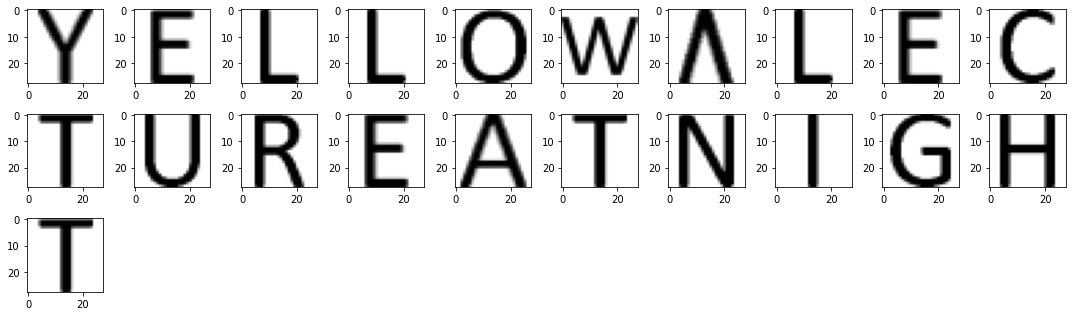

In [110]:
# plot isolated characters
n_cols = 10
n_rows = np.floor(len(chars)/ n_cols)+1
fig = plt.figure(figsize=(1.5*n_cols,1.5*n_rows))
for i,char in enumerate(chars):
  ax = plt.subplot(int(n_rows),int(n_cols),i+1)
  ax.imshow(char[0][:,:,0],cmap=cm.binary,aspect='auto')
  #plt.axis('off')
plt.tight_layout()

In [111]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)




# define the list of label names
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

Upper Left Corner of Rectangles: [74, 127, 174, 214, 250, 313, 336, 425, 465, 508, 555, 610, 672, 724, 801, 855, 932, 994, 1014, 1079, 1131, 0]
Upper Right Corner of Rectangles: [117, 161, 206, 246, 305, 393, 371, 457, 499, 553, 601, 656, 713, 758, 853, 901, 978, 1003, 1064, 1123, 1177]
Consecutive Differences Between Each Corners: [10, 13, 8, 4, 8, -57, 54, 8, 9, 2, 9, 16, 11, 43, 2, 31, 16, 11, 15, 8, -1177]
Characters: ['Y', 'E', 'L', 'L', 'O', 'W', 'A', ' ', 'L', 'E', 'C', 'T', 'U', 'R', 'E', ' ', 'A', 'T', ' ', 'N', '1', 'G', 'H', 'T']
Raw Sentence: YELLOWA LECTURE AT N1GHT
Corrected Sentence: YELLOW LECTURE AT NIGHT
Translated Sentence: Geceleri sarı ders


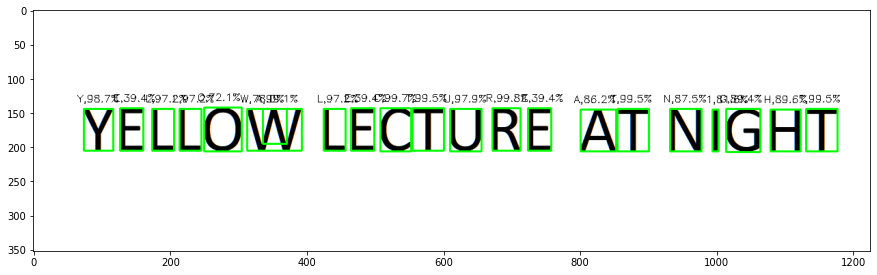

In [112]:
image = cv2.imread(image_path)
cropped = image[5:,:]
euc=[]


for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
  euc.append(label)

  # draw the prediction on the image and it's probability
  label_text = f"{label},{prob * 100:.1f}%"
  cv2.rectangle(cropped, (x, y), (x + w, y + h), (0,255 , 0), 2)
 


  cv2.putText(cropped, label_text, (x - 10, y - 10),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,0), 1)
# show the image


mylist_x.append(0)
print("Upper Left Corner of Rectangles:",mylist_x)
print("Upper Right Corner of Rectangles:",mylist_w)                 

differences=[]

for i in range(len(mylist_w)):
  first=mylist_x[i+1]-mylist_w[i]
  differences.append(first)
print("Consecutive Differences Between Each Corners:",differences)


characters=[]
for i,j in zip(range(len(differences)),range(len(euc))):
  
  characters.append(euc[j])
  if differences[i]>30:
    characters.append(" ")


print("Characters:",characters)

output="".join(characters)  


output_split=output.split()

print("Raw Sentence:",output)

from spellchecker import SpellChecker
 
spell = SpellChecker()
 


for i in range(len(output_split)):
    # Get the one `most likely` answer
    correct=spell.correction(output_split[i])
    output_split[i]=correct.upper()


output_split=" ".join(output_split)
    
print("Corrected Sentence:",output_split)


import translators as ts
trans=ts.google(output_split,to_language='tr')

print("Translated Sentence:",trans)
  

plt.figure(figsize=(15,10))

plt.imshow(cropped)



blank_image_path="blank.JPG"
blank_image=cv2.imread(blank_image_path)


# cv2.putText(blank_image, trans, (150,130),cv2.FONT_HERSHEY_SIMPLEX,2, (0,0,0), 2)

# plt.figure(figsize=(15,10))
# plt.imshow(blank_image)

# Importing the PIL library
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
 
# Open an Image
img = Image.open('blank.jpg')
# Call draw Method to add 2D graphics in an image
I1 = ImageDraw.Draw(img)
 
# Custom font style and font size
myFont = ImageFont.truetype('OpenSans-Regular.ttf', 65)
 
# Add Text to an image
I1.text((50, 50), trans, font=myFont, fill =(255, 0, 0))
img.save("translated.jpg")
from IPython.display import Image 
pil_img = Image(filename='translated.jpg')






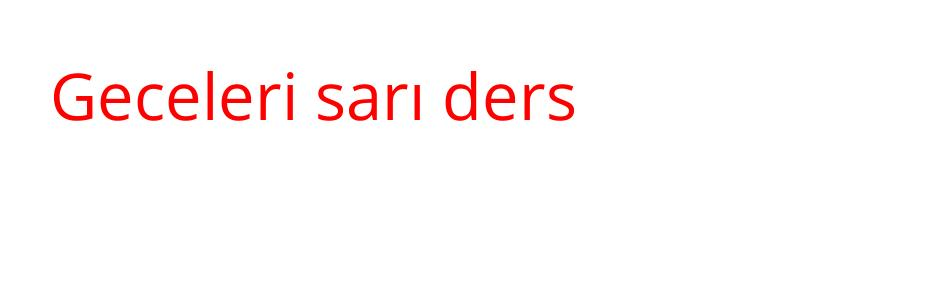

In [113]:
display(pil_img)